<a href="https://colab.research.google.com/github/jdoijad15115/DR-Techniques-and-Clustering/blob/main/DR_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 EuroSAT Dataset Description

The **EuroSAT** dataset is a labeled satellite image dataset derived from the **Sentinel-2** satellite mission, designed for land use and land cover classification tasks. It contains **27,000 images** covering diverse European landscapes, split across **10 different classes**.

---

## 📌 Key Features

- **Image Size:** 64x64 pixels with 3 RGB channels  
- **Total Images:** 27,000 satellite images  
- **Classes:** 10 land use/land cover categories:
  - 🏘️ **Residential**  
  - 🏭 **Industrial**  
  - 🛣️ **Highway**  
  - 🌊 **River**  
  - 🌳 **Forest**  
  - 🌾 **Pasture**  
  - 🌱 **Herbaceous vegetation**  
  - 🚜 **Agricultural land**  
  - 🏖️ **Sea/Lake**  
  - 🌴 **Permanent crop**  

- **Source:** Data collected from the **Sentinel-2** satellite, providing multi-spectral imaging with high spatial resolution.

---

## 🔍 Why EuroSAT is Suitable for Dimensionality Reduction?

- **High-dimensional input:** Each image (64x64x3) results in **12,288 features per image** — ideal for dimensionality reduction techniques.  
- **Diverse classes:** Helps visualize how well different algorithms separate land cover types.  
- **Real-world relevance:** Useful for urban planning, agriculture, and environmental monitoring tasks.

---
  
  

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, MDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')





##  **Download the EuroSAT Dataset**
The code loads images from subfolders within a given directory, where each subfolder represents a distinct class. It iterates through each subfolder, reads the image files, resizes them to a standard size (defaulting to 64x64 pixels), and appends the resized images to a list. Alongside each image, it stores an associated class label, which is determined by the subfolder's name. These labels are mapped to integer values to make them suitable for machine learning tasks. A progress bar is displayed while loading the images. After processing all the images, the code returns two arrays: one containing the images and the other containing their corresponding labels, as well as a list of class names. Finally, it prints the total number of images loaded and the number of unique classes identified in the dataset.





In [ ]:
# ------------------ STEP 1: Load images ------------------ #
def load_images_from_folder(folder, img_size=(64, 64)):
    X, y = [], []
    class_names = sorted(os.listdir(folder))
    label_map = {class_name: i for i, class_name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if not os.path.isdir(class_folder): continue
        for filename in tqdm(os.listdir(class_folder), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label_map[class_name])
    return np.array(X), np.array(y), class_names

dataset_path = "./2750"
X, y, class_names = load_images_from_folder(dataset_path)
print(f"\nLoaded {len(X)} images across {len(class_names)} classes.")


Loading SeaLake: 100%|████████████████████| 3000/3000 [00:00<00:00, 4896.30it/s]



Loaded 27000 images across 10 classes.


## **Explore the Dataset Structure**
The code visualizes a set of random sample images from different classes within a dataset. It first initializes a grid of subplots with a number of rows equal to the number of classes and columns equal to the number of samples specified. Then, for each class, it randomly selects a set number of image files, reads each image using OpenCV, converts it from BGR to RGB color format, and displays the image in the corresponding subplot. The title of each row (subplots corresponding to a class) is set to the class name. The axes are turned off for each image to eliminate extra details like axis numbers. After displaying the images, the layout is adjusted to prevent overlap, and the plot is shown to the user. This function is designed to allow quick inspection of random images from different categories in the dataset.


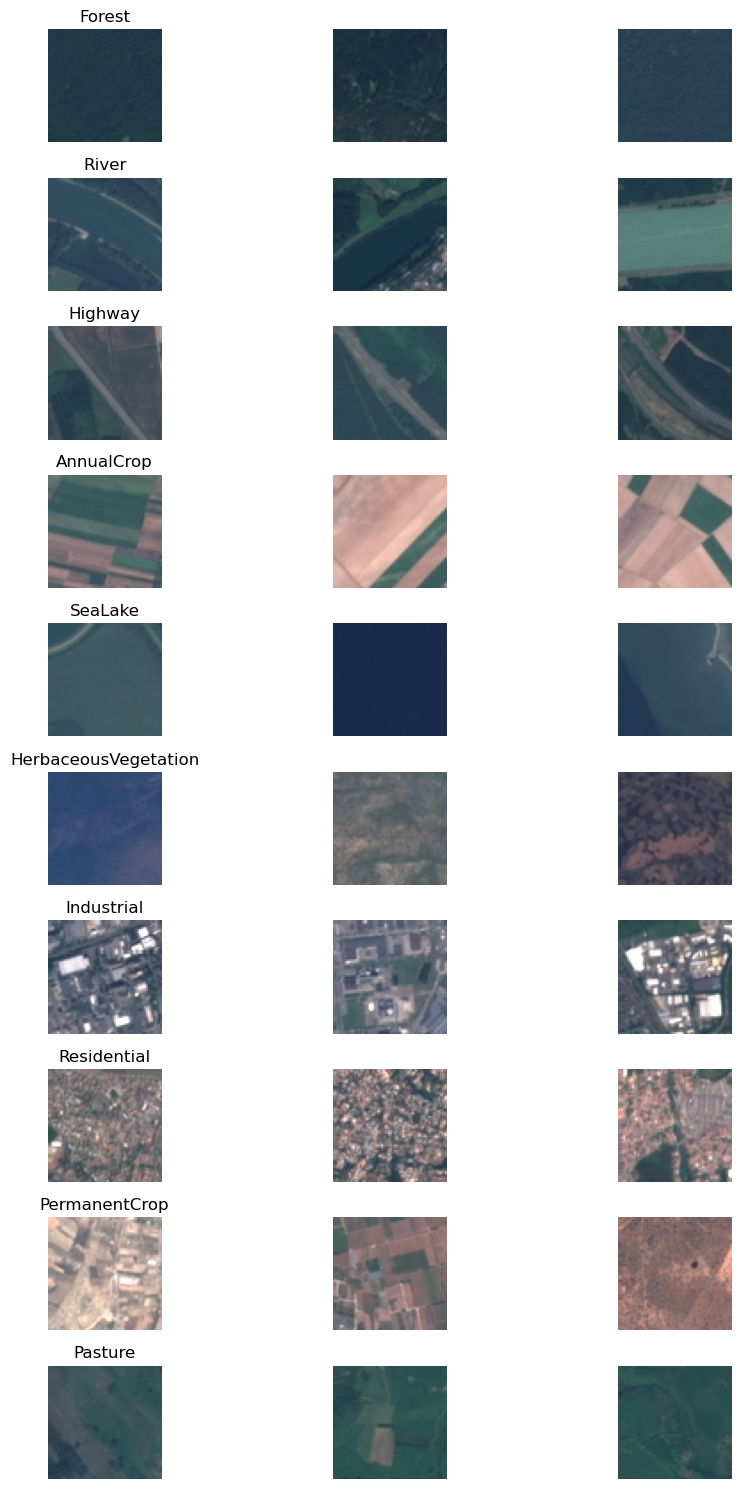

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def show_samples(dataset_path, classes, samples=3):
    fig, axes = plt.subplots(len(classes), samples, figsize=(10, 15))

    for i, category in enumerate(classes):
        category_path = os.path.join(dataset_path, category)
        images = random.sample(os.listdir(category_path), samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

show_samples(dataset_path, os.listdir(dataset_path))


### 📊2 Check Image Dimensions
The code checks the sizes of the images in a dataset to identify if there are any variations. It iterates through each category (subfolder) in the dataset, opens the first image in each category using the PIL library, and appends the image's size (width and height) to a list. After processing all the categories, it prints out the unique image sizes by converting the list of sizes into a set (which removes duplicates). This helps determine if all images in the dataset have the same dimensions or if there are any inconsistencies in size across the images.


In [ ]:
from PIL import Image

image_sizes = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    img_path = os.path.join(category_path, os.listdir(category_path)[0])
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

print("🛠️ Unique image sizes:", set(image_sizes))


🛠️ Unique image sizes: {(64, 64)}


### 📈 3 Class Distribution

This code counts the number of files in each category within a dataset directory and visualizes the distribution of these counts in a bar plot using seaborn. It reads the file counts into a pandas DataFrame, then creates and displays a bar plot of the class distribution.

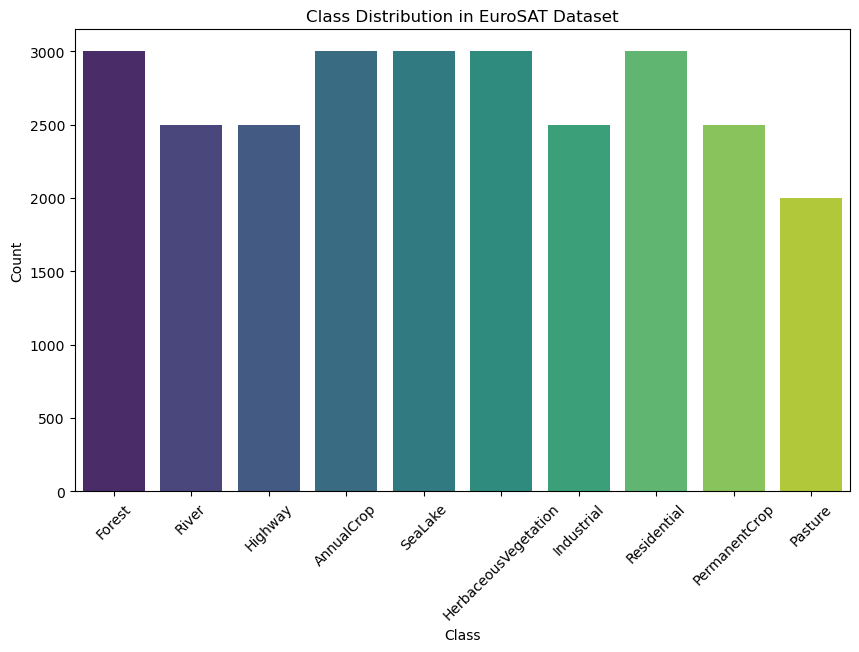

In [ ]:
import pandas as pd
import seaborn as sns

class_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in os.listdir(dataset_path)}

df_class_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
plt.figure(figsize=(10, 6))
sns.barplot(data=df_class_counts, x="Class", y="Count", palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


### 4 Compute Basic Statistics
This code loads images from a dataset, where each subdirectory represents a different category, and converts each image into a NumPy array. It then stores all the images in a list, which is eventually converted into a 3D NumPy array (with dimensions corresponding to the number of images, image height, width, and color channels). After loading the images, the code prints the dataset's shape (number of images and dimensions), the minimum and maximum pixel values across all images, and the mean and standard deviation of the pixel values. These statistics provide a quick overview of the dataset's size and the pixel value distribution, which can be helpful for understanding the dataset's characteristics before performing further image processing or machine learning tasks.


In [ ]:
import numpy as np

all_images = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = np.array(Image.open(img_path))
        all_images.append(img)

all_images = np.array(all_images)

print("🔹 Dataset Shape:", all_images.shape)
print("🔹 Pixel Range: Min =", all_images.min(), ", Max =", all_images.max())
print("🔹 Mean Pixel Value:", all_images.mean())
print("🔹 Standard Deviation:", all_images.std())


🔹 Dataset Shape: (27000, 64, 64, 3)
🔹 Pixel Range: Min = 0 , Max = 255
🔹 Mean Pixel Value: 96.25729956657504
🔹 Standard Deviation: 40.417929895670405


### 5 Compute Basic Statistics and color analysis

This code calculates the average RGB values for images in each class of a dataset and visualizes these average values in a bar plot. It first lists all the class names in the dataset. Then, for each class, it reads a few images (up to 10 for efficiency), calculates their average RGB values, and stores the overall average RGB value for each class. Afterward, it plots these average RGB values for each class using a bar plot, with separate bars for the red, green, and blue channels. The bars are labeled by class names, and a legend indicates which color corresponds to which channel.

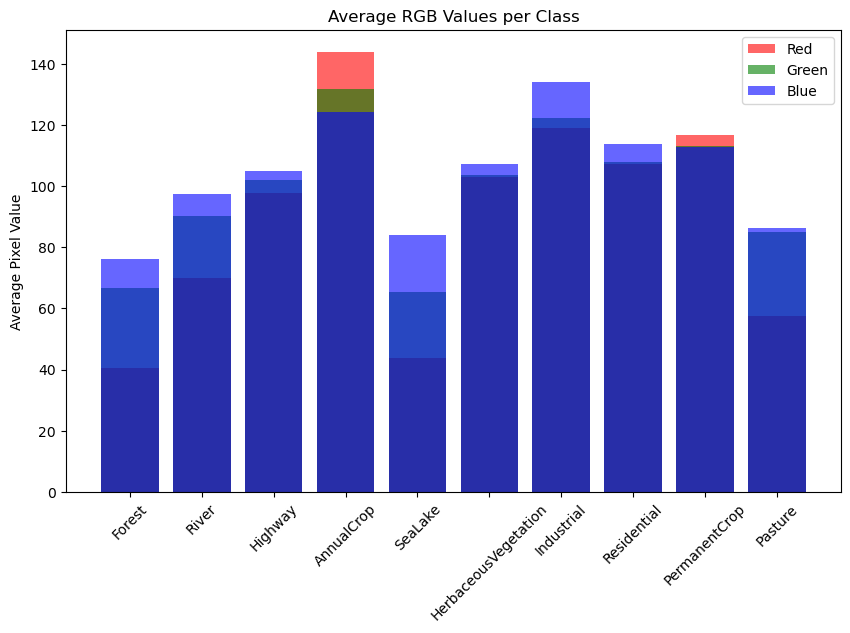

In [ ]:
class_names = os.listdir(dataset_path)

# Function to calculate average RGB values
def calculate_avg_rgb(image_path):
    img = cv2.imread(image_path)  # Read the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return np.mean(img_rgb, axis=(0, 1))  # Calculate mean RGB values

# Store average colors per class
class_colors = {}

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    color_totals = []

    # Go through a few images per class to get average colors
    for i, img_file in enumerate(os.listdir(class_folder)):
        if i >= 10:  # Limit to 10 images per class for speed
            break
        img_path = os.path.join(class_folder, img_file)
        color_totals.append(calculate_avg_rgb(img_path))

    # Get the overall average RGB for this class
    class_colors[class_name] = np.mean(color_totals, axis=0)

# Plotting average RGB values per class
plt.figure(figsize=(10, 6))
for class_name, color in class_colors.items():
    plt.bar(class_name, color[0], color='red', label='Red', alpha=0.6)
    plt.bar(class_name, color[1], color='green', label='Green', alpha=0.6)
    plt.bar(class_name, color[2], color='blue', label='Blue', alpha=0.6)

plt.title("Average RGB Values per Class")
plt.ylabel("Average Pixel Value")
plt.xticks(rotation=45)
plt.legend(["Red", "Green", "Blue"])
plt.show()

### 📌 6. Histogram of Pixel Intensities

This code selects one sample image from each class in the dataset (up to the first 10 classes) and displays its pixel intensity histogram. For each class, it reads the first image in the class folder, converts it to grayscale, and plots the histogram of pixel intensities. The histograms show how frequently each pixel intensity value (from 0 to 255) occurs in the image. The code uses subplots to display multiple histograms on one figure, with each subplot corresponding to a different class. The histograms are labeled with the class name and axes indicating pixel intensity and frequency. Finally, the tight_layout function ensures the subplots are properly arranged without overlap.

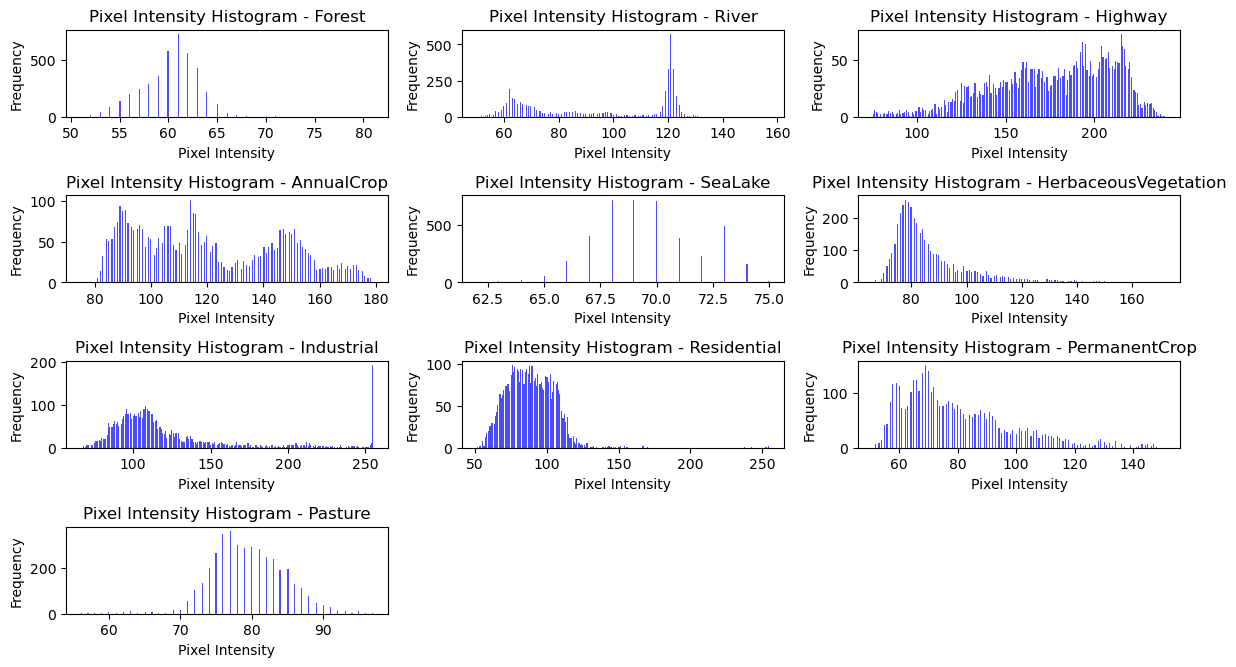

In [ ]:
# Let's pick one sample image from each class for demonstration
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names[:10]):  # Limit to 6 classes for clarity
    class_folder = os.path.join(dataset_path, class_name)
    sample_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

    # Plot histogram for this class's sample image
    plt.subplot(5, 3, i + 1)
    plt.hist(sample_image.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title(f"Pixel Intensity Histogram - {class_name}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(False)

plt.tight_layout()
plt.show()


### 7. Correlation Matrix

This code loads a sample multi-band image (simulated using the RGB color bands) from a specified dataset and performs a correlation analysis between the image's color channels (Red, Green, Blue). It first reads the image using OpenCV (cv2.imread()) and then flattens each color channel (Red, Green, Blue) into a 1D array. These flattened arrays are organized into a pandas DataFrame, with each column representing a color channel. The code then computes the correlation matrix between the color bands using the .corr() method of pandas. Finally, it visualizes this correlation matrix using a heatmap created with Seaborn (sns.heatmap()), which highlights the strength of correlations between the color channels, providing insights into how the color bands relate to one another. The heatmap is annotated with correlation values and displayed with a color gradient.

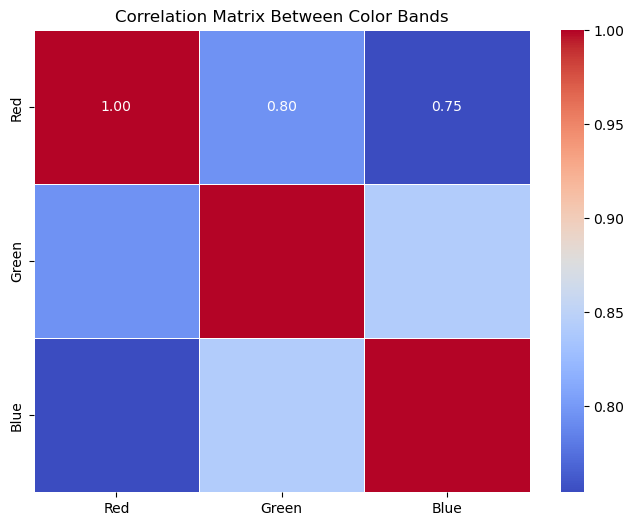

In [ ]:
import pandas as pd
import seaborn as sns

# Let's load one sample multi-band image (if applicable)
# For EuroSAT RGB, we simulate this by stacking R, G, B as bands
sample_image_path = os.path.join(dataset_path, class_names[0], os.listdir(os.path.join(dataset_path, class_names[0]))[0])
sample_image = cv2.imread(sample_image_path)
bands = ['Red', 'Green', 'Blue']

# Flatten the image into columns of pixels per band
flattened_bands = [sample_image[:, :, i].flatten() for i in range(3)]

# Create DataFrame for correlation analysis
df_bands = pd.DataFrame(np.array(flattened_bands).T, columns=bands)

# Correlation matrix
correlation_matrix = df_bands.corr()

# Plotting correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between Color Bands")
plt.show()


## Feature extraction



ResNet50 Feature Extraction

This code performs feature extraction using the ResNet50 model, pre-trained on the ImageNet dataset. It initializes the ResNet50 model with pre-trained weights, excluding the top classification layer (include_top=False) and using average pooling (pooling='avg') for output. The input images are resized to 64x64 pixels with 3 color channels (RGB) and passed through the model after being preprocessed with the preprocess_input function. The model then generates feature vectors for each image, capturing high-level representations learned from the ImageNet dataset. These feature vectors are stored in the features variable, which can later be used for tasks like classification or clustering.


In [ ]:
# ------------------ STEP 3: Feature Extraction (ResNet50) ------------------ #
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3), pooling='avg')
X_prep = preprocess_input(X)
features = resnet.predict(X_prep, verbose=1)

844/844 ━━━━━━━━━━━━━━━━━━━━ 175s 205ms/step


## Train-Test Split

This code splits the dataset into training and testing sets using the train_test_split function from Scikit-learn. It takes the extracted feature vectors (features) and their corresponding labels (y) as input. The test_size=0.3 parameter indicates that 30% of the data will be used for testing, while the remaining 70% will be used for training. The stratify=y parameter ensures that the class distribution in both the training and testing sets is similar to that of the original dataset, maintaining the same proportion of each class. The random_state=42 ensures reproducibility by setting a fixed seed for random operations. The resulting splits are stored in X_train, X_test, y_train, and y_test for further model training and evaluation.

In [ ]:
# ------------------ STEP 4: Train-Test Split ------------------ #
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, stratify=y, random_state=42)


## define ML models

This code defines a dictionary called models, which contains several machine learning classifiers, each configured with specific hyperparameters. The models include a Random Forest classifier with 100 trees and a fixed random seed, an SVM (RBF) classifier using a Radial Basis Function kernel, a regularization parameter C=10, and probability estimates enabled. The XGBoost model is configured with 100 estimators, multi-class log loss as the evaluation metric, and a fixed random state. The MLP classifier is defined with two hidden layers of 256 and 128 neurons, a maximum of 300 iterations, and early stopping to prevent overfitting. These models are organized in the dictionary for easy access, allowing for systematic comparison and evaluation during training.

In [ ]:
# ------------------ STEP 5: Define ML Models ------------------ #
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, early_stopping=True, random_state=42)
}

## Evaluation Functions

This code defines two evaluation functions to assess the performance of machine learning models after applying dimensionality reduction. The first function, evaluate_models_transformable, applies dimensionality reduction (e.g., LDA) to the training and test data, then trains and evaluates each model from the models dictionary on the reduced data. It outputs accuracy scores and detailed classification reports for each model. The second function, evaluate_models_no_transform, applies dimensionality reduction to the entire dataset and splits it into training and testing sets. It then evaluates the models by training them on the reduced training data and printing the accuracy and classification report. These functions provide a way to compare model performance both with and without dimensionality reduction applied, offering insight into how dimensionality reduction affects classification results.

In [ ]:
# ------------------ STEP 6: Evaluation Functions ------------------ #
def evaluate_models_transformable(X_train, X_test, y_train, y_test, reducer, method_name):
    print(f"\n=== {method_name} ===")
    if method_name == "LDA":
        reducer.fit(X_train, y_train)
    else:
        reducer.fit(X_train)
    X_train_red = reducer.transform(X_train)
    X_test_red = reducer.transform(X_test)

    for name, clf in models.items():
        print(f"\n→ {name}")
        clf.fit(X_train_red, y_train)
        y_pred = clf.predict(X_test_red)
        print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names))

def evaluate_models_no_transform(X, y, reducer, method_name):
    print(f"\n=== {method_name} ===")
    X_red = reducer.fit_transform(X)
    X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y, test_size=0.3, stratify=y, random_state=42)

    for name, clf in models.items():
        print(f"\n→ {name}")
        clf.fit(X_train_red, y_train_red)
        y_pred = clf.predict(X_test_red)
        print(f"{name} Accuracy: {accuracy_score(y_test_red, y_pred):.4f}")
        print(classification_report(y_test_red, y_pred, target_names=class_names))


## Apply Dimensionality Reduction

This code applies three different dimensionality reduction techniques—PCA, TruncatedSVD, and LDA—on the training and test data and evaluates the performance of machine learning models after the transformation. The evaluate_models_transformable function is called three times, each time with a different dimensionality reduction method: Principal Component Analysis (PCA) with 50 components, Truncated Singular Value Decomposition (SVD) with 50 components, and Linear Discriminant Analysis (LDA) with 9 components. For each method, the function reduces the dimensionality of the data, trains the models, and prints their accuracy scores and classification reports. This step allows for comparing how each dimensionality reduction technique affects the model's performance.

In [ ]:
# ------------------ STEP 7: Apply Dimensionality Reduction ------------------ #
evaluate_models_transformable(X_train, X_test, y_train, y_test, PCA(n_components=50), "PCA")
evaluate_models_transformable(X_train, X_test, y_train, y_test, TruncatedSVD(n_components=50), "SVD")
evaluate_models_transformable(X_train, X_test, y_train, y_test, LDA(n_components=9), "LDA")



=== PCA ===

→ Random Forest
Random Forest Accuracy: 0.8748
                      precision    recall  f1-score   support

              Forest       0.87      0.90      0.88       900
               River       0.92      0.96      0.94       900
             Highway       0.85      0.92      0.88       900
          AnnualCrop       0.77      0.75      0.76       750
             SeaLake       0.89      0.92      0.90       750
HerbaceousVegetation       0.87      0.87      0.87       600
          Industrial       0.84      0.74      0.79       750
         Residential       0.92      0.93      0.92       900
       PermanentCrop       0.81      0.80      0.80       750
             Pasture       0.98      0.92      0.95       900

            accuracy                           0.87      8100
           macro avg       0.87      0.87      0.87      8100
        weighted avg       0.87      0.87      0.87      8100


→ SVM (RBF)
SVM (RBF) Accuracy: 0.9207
                      precis

##  t-SNE and MDS on Subset

This code applies t-SNE and MDS dimensionality reduction techniques on a random subset of 1000 samples from the dataset and evaluates the performance of machine learning models. First, a random subset of 1000 samples is selected from the features array using np.random.choice. Then, the evaluate_models_no_transform function is called twice: once with t-SNE (t-Distributed Stochastic Neighbor Embedding) with 2 components and a perplexity of 30, and once with MDS (Multidimensional Scaling) with 2 components. Both methods are applied to the subset of data, and for each, the models are trained and evaluated, with accuracy scores and classification reports being printed. This step helps to understand how t-SNE and MDS, which are often used for visualization, affect the model's performance when applied to a smaller subset of the data.

In [ ]:
# ------------------ STEP 8: t-SNE and MDS on Subset ------------------ #
idx = np.random.choice(len(features), 1000, replace=False)
X_sample, y_sample = features[idx], y[idx]
evaluate_models_no_transform(X_sample, y_sample, TSNE(n_components=2, perplexity=30, random_state=42), "t-SNE")
evaluate_models_no_transform(X_sample, y_sample, MDS(n_components=2, random_state=42), "MDS")



=== t-SNE ===

→ Random Forest
Random Forest Accuracy: 0.7500
                      precision    recall  f1-score   support

              Forest       0.84      0.97      0.90        33
               River       0.73      0.69      0.71        32
             Highway       0.67      0.85      0.75        34
          AnnualCrop       0.50      0.59      0.54        27
             SeaLake       0.93      0.81      0.87        32
HerbaceousVegetation       0.83      0.75      0.79        20
          Industrial       0.75      0.58      0.65        26
         Residential       0.75      0.86      0.80        35
       PermanentCrop       0.58      0.38      0.46        29
             Pasture       0.91      0.91      0.91        32

            accuracy                           0.75       300
           macro avg       0.75      0.74      0.74       300
        weighted avg       0.75      0.75      0.74       300


→ SVM (RBF)
SVM (RBF) Accuracy: 0.7367
                      prec

## 2D & 3D Visualizations

This code generates 2D and 3D visualizations of data projections using various dimensionality reduction techniques. First, two helper functions are defined: plot_2D_projection creates a 2D scatter plot of the reduced data, with points colored by their class labels, and plot_3D_projection creates a 3D scatter plot of the reduced data with points grouped by their class labels. The visualizations are produced using different dimensionality reduction methods: PCA, SVD, LDA, t-SNE, and MDS. For PCA and SVD, both 2D and 3D projections are visualized. For LDA, t-SNE, and MDS, only 2D projections are created. These plots help to visually explore the structure of the data in reduced dimensions, revealing how well the data can be separated by different techniques and providing insights into class distributions.

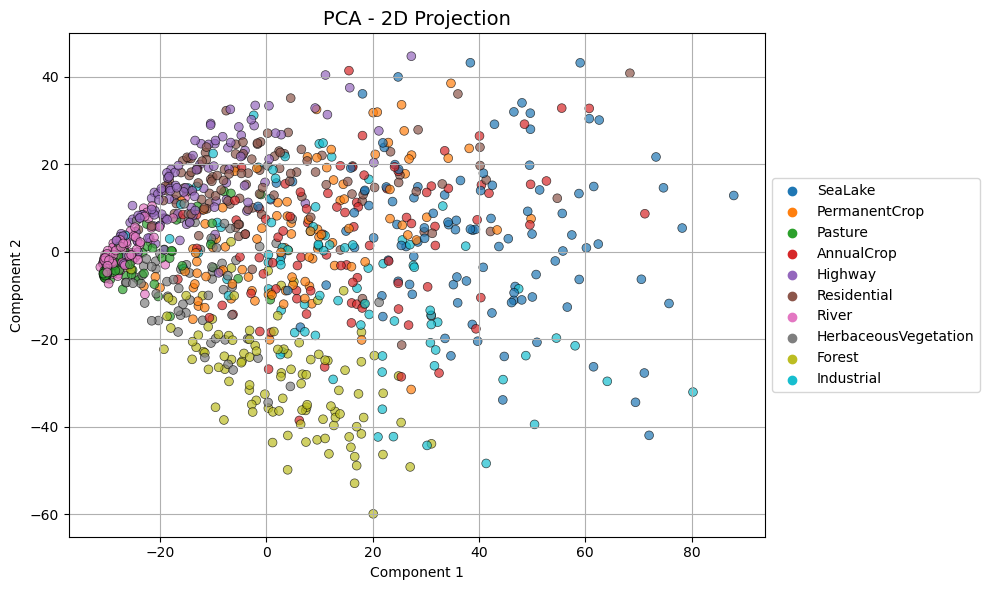

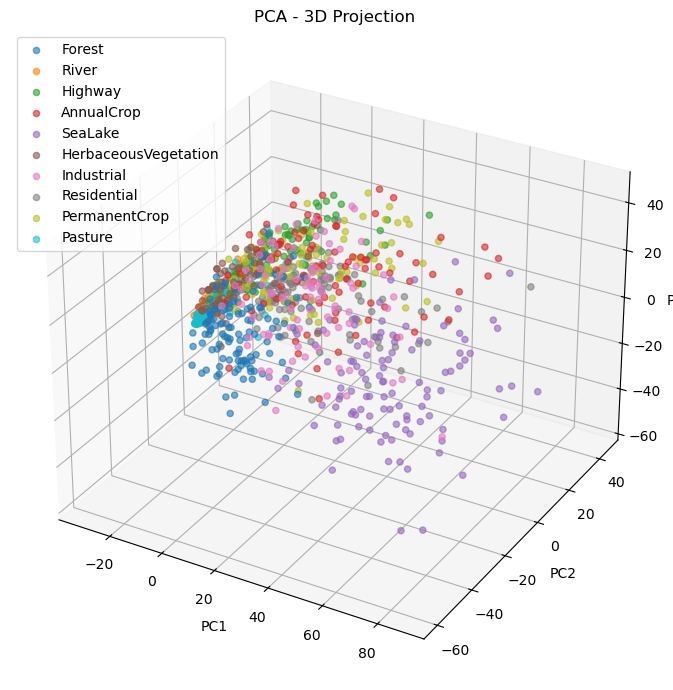

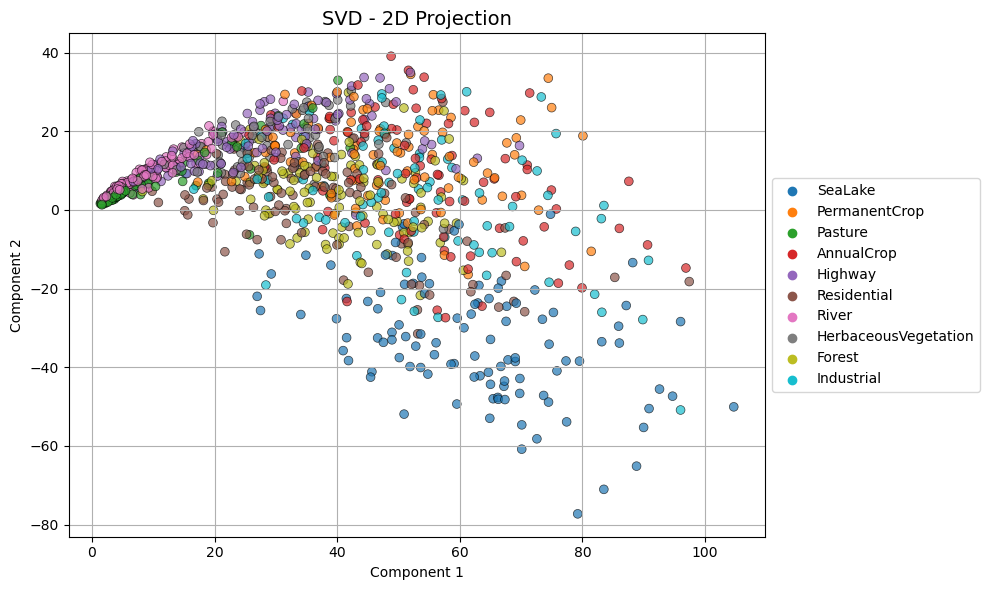

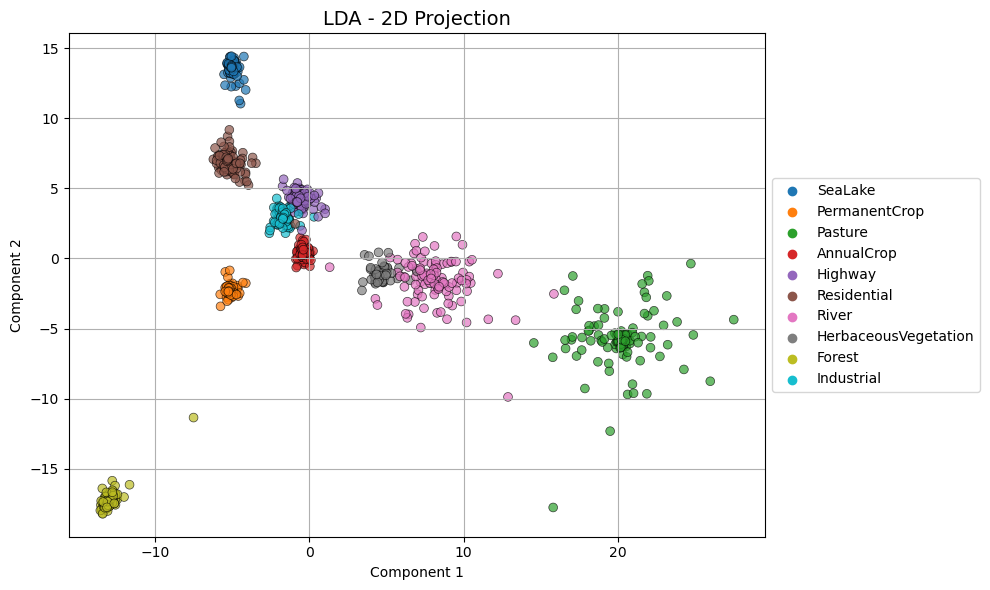

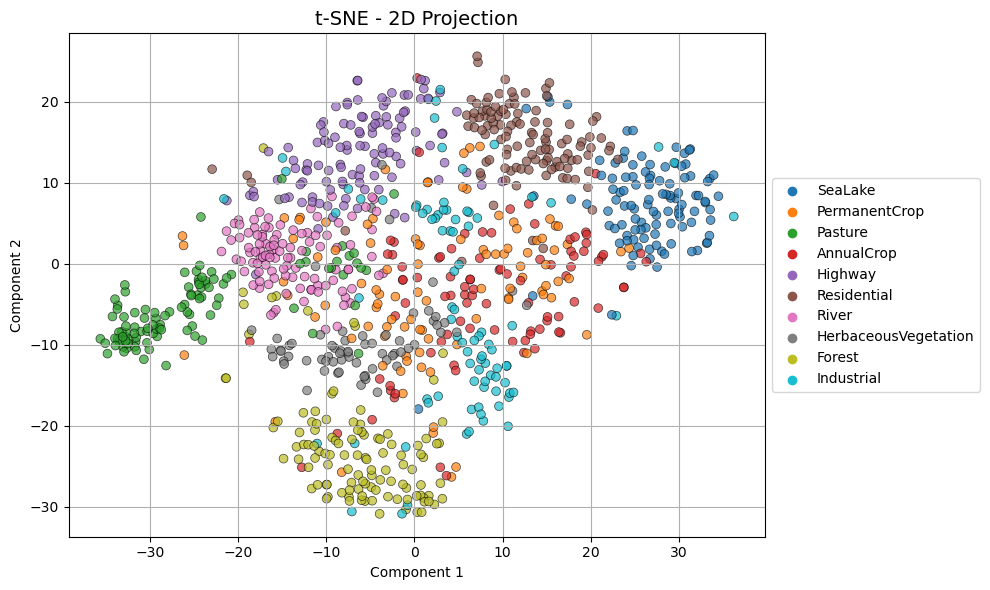

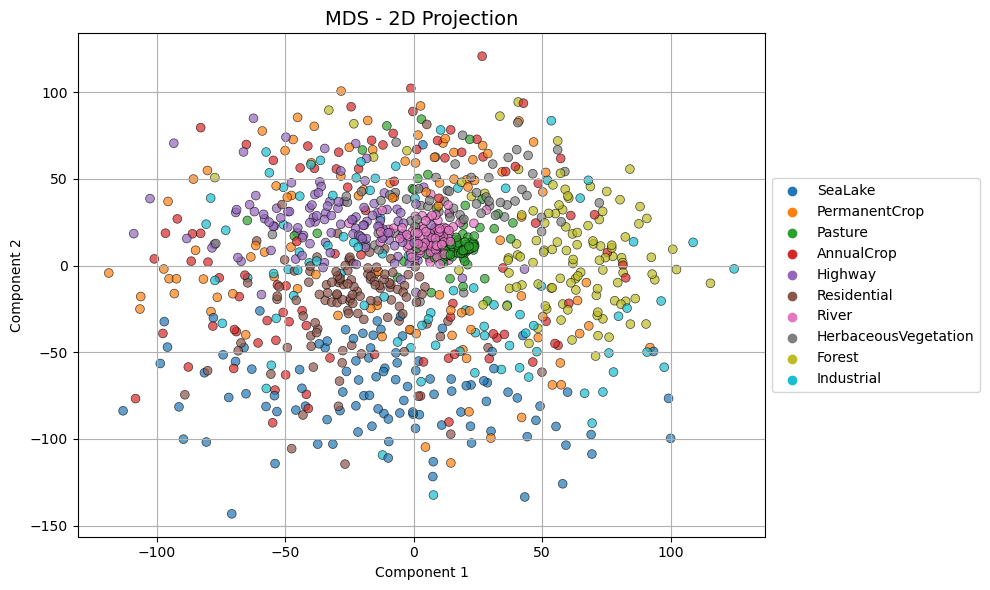

In [ ]:
# ------------------ STEP 9: 2D & 3D Visualizations ------------------ #
def plot_2D_projection(X_2d, y_labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=[class_names[i] for i in y_labels],
                    palette='tab10', s=40, edgecolor='k', alpha=0.7, legend='full')
    plt.title(f"{title} - 2D Projection", fontsize=14)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_3D_projection(X_3d, y_labels, title):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    for i in np.unique(y_labels):
        ix = np.where(y_labels == i)
        ax.scatter(X_3d[ix, 0], X_3d[ix, 1], X_3d[ix, 2], label=class_names[i], s=20, alpha=0.6)
    ax.set_title(f"{title} - 3D Projection")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

# PCA 2D & 3D
pca_2d = PCA(n_components=2).fit_transform(X_sample)
plot_2D_projection(pca_2d, y_sample, "PCA")

pca_3d = PCA(n_components=3).fit_transform(X_sample)
plot_3D_projection(pca_3d, y_sample, "PCA")

# SVD 2D
svd_2d = TruncatedSVD(n_components=2).fit_transform(X_sample)
plot_2D_projection(svd_2d, y_sample, "SVD")

# LDA 2D
lda_2d = LDA(n_components=2).fit(X_sample, y_sample).transform(X_sample)
plot_2D_projection(lda_2d, y_sample, "LDA")

# t-SNE 2D
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_sample)
plot_2D_projection(tsne_2d, y_sample, "t-SNE")

# MDS 2D
mds_2d = MDS(n_components=2, random_state=42).fit_transform(X_sample)
plot_2D_projection(mds_2d, y_sample, "MDS")

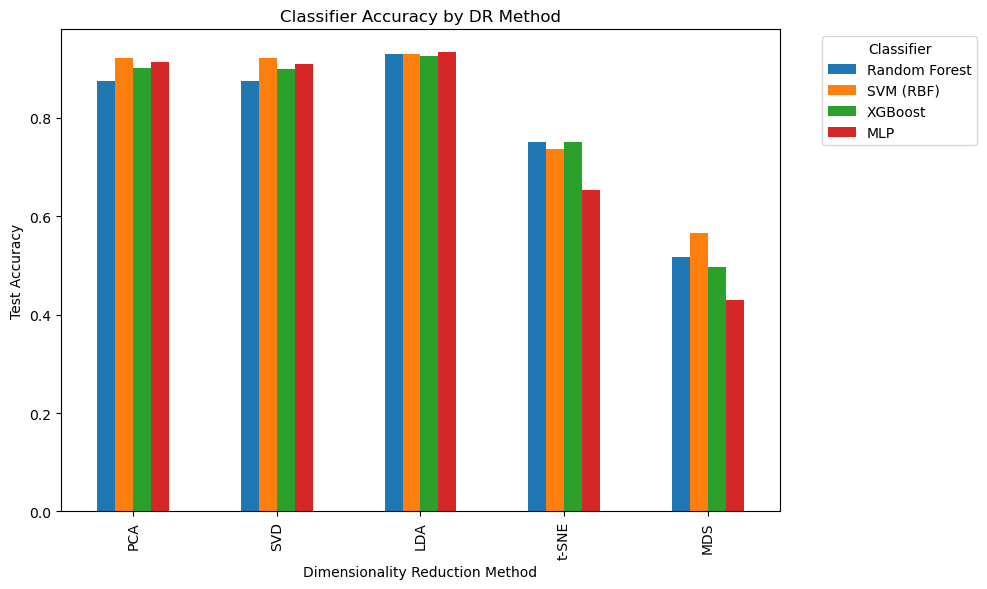

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Example: reconstruct from your printed outputs
performance = {
    'PCA':    {'Random Forest':0.8748, 'SVM (RBF)':0.9207, 'XGBoost':0.9021, 'MLP':0.9138},
    'SVD':    {'Random Forest':0.8753, 'SVM (RBF)':0.9212, 'XGBoost':0.9002, 'MLP':0.9095},
    'LDA':    {'Random Forest':0.9293, 'SVM (RBF)':0.9296, 'XGBoost':0.9267, 'MLP':0.9333},
    't‑SNE':  {'Random Forest':0.7500, 'SVM (RBF)':0.7367, 'XGBoost':0.7500, 'MLP':0.6533},
    'MDS':    {'Random Forest':0.5167, 'SVM (RBF)':0.5667, 'XGBoost':0.4967, 'MLP':0.4300},
}

# 2) Turn it into a DataFrame (rows=methods, cols=classifiers)
df_perf = pd.DataFrame(performance).T

# 3) Plot a grouped bar chart
ax = df_perf.plot(kind='bar', figsize=(10,6))
ax.set_xlabel('Dimensionality Reduction Method')
ax.set_ylabel('Test Accuracy')
ax.set_title('Classifier Accuracy by DR Method')
ax.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


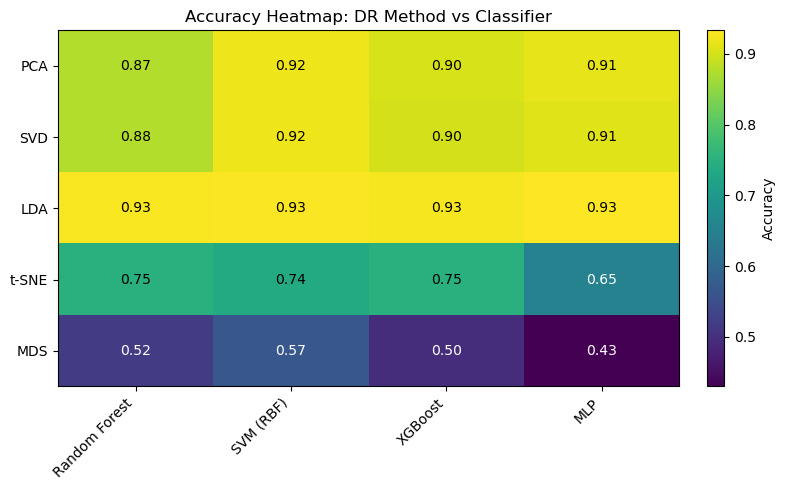

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Reconstruct your results dict (from your printed outputs)
performance = {
    'PCA':   {'Random Forest':0.8748, 'SVM (RBF)':0.9207, 'XGBoost':0.9021, 'MLP':0.9138},
    'SVD':   {'Random Forest':0.8753, 'SVM (RBF)':0.9212, 'XGBoost':0.9002, 'MLP':0.9095},
    'LDA':   {'Random Forest':0.9293, 'SVM (RBF)':0.9296, 'XGBoost':0.9267, 'MLP':0.9333},
    't‑SNE': {'Random Forest':0.7500, 'SVM (RBF)':0.7367, 'XGBoost':0.7500, 'MLP':0.6533},
    'MDS':   {'Random Forest':0.5167, 'SVM (RBF)':0.5667, 'XGBoost':0.4967, 'MLP':0.4300},
}

# 2) DataFrame for easy plotting
df_perf = pd.DataFrame(performance).T

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(8, 5))
# Display the matrix
im = ax.imshow(df_perf.values, aspect='auto')

# Tick labels
ax.set_xticks(np.arange(len(df_perf.columns)))
ax.set_yticks(np.arange(len(df_perf.index)))
ax.set_xticklabels(df_perf.columns, rotation=45, ha='right')
ax.set_yticklabels(df_perf.index)

# Annotate each cell with its accuracy
for i in range(df_perf.shape[0]):
    for j in range(df_perf.shape[1]):
        text_color = 'white' if df_perf.values[i, j] < 0.7 else 'black'
        ax.text(j, i, f"{df_perf.values[i, j]:.2f}",
                ha='center', va='center', color=text_color)

ax.set_title('Accuracy Heatmap: DR Method vs Classifier')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Accuracy')
plt.tight_layout()
plt.show()


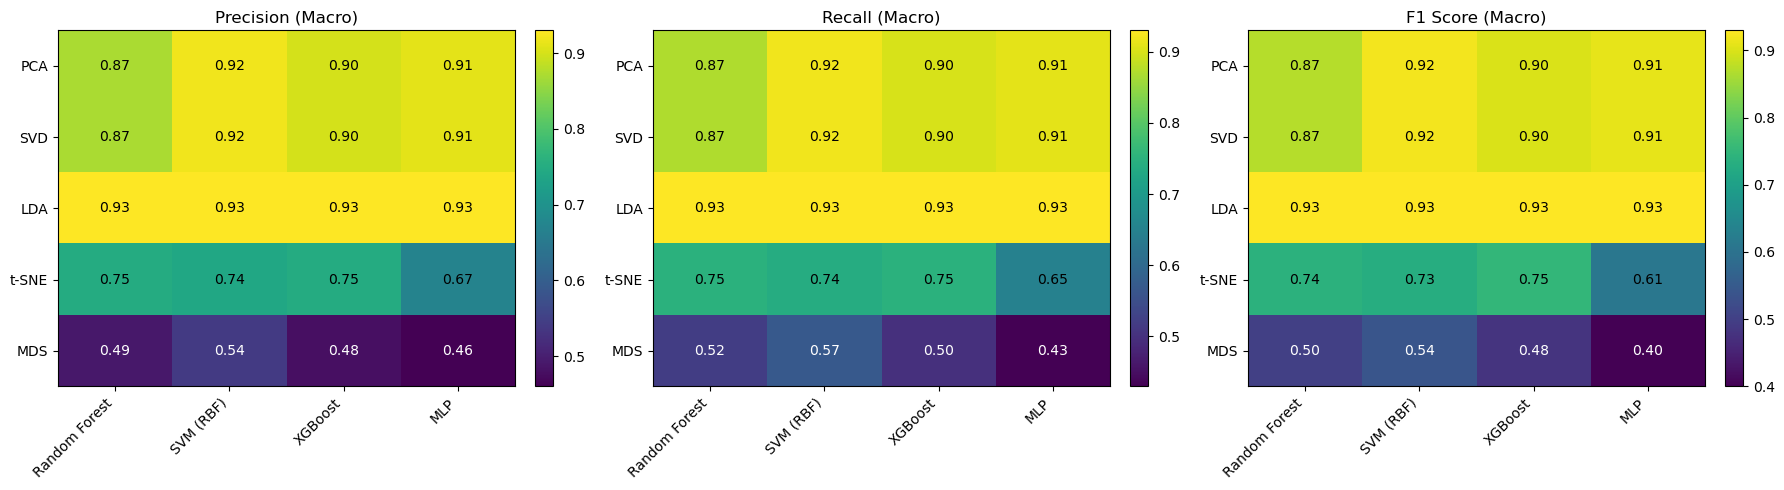

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example metric dictionary (use your real scores)
metrics = {
    'PCA':   {'Random Forest':{'precision':0.87,'recall':0.87,'f1':0.87},
              'SVM (RBF)':    {'precision':0.92,'recall':0.92,'f1':0.92},
              'XGBoost':      {'precision':0.90,'recall':0.90,'f1':0.90},
              'MLP':          {'precision':0.91,'recall':0.91,'f1':0.91}},
    'SVD':   {'Random Forest':{'precision':0.87,'recall':0.87,'f1':0.87},
              'SVM (RBF)':    {'precision':0.92,'recall':0.92,'f1':0.92},
              'XGBoost':      {'precision':0.90,'recall':0.90,'f1':0.90},
              'MLP':          {'precision':0.91,'recall':0.91,'f1':0.91}},
    'LDA':   {'Random Forest':{'precision':0.93,'recall':0.93,'f1':0.93},
              'SVM (RBF)':    {'precision':0.93,'recall':0.93,'f1':0.93},
              'XGBoost':      {'precision':0.93,'recall':0.93,'f1':0.93},
              'MLP':          {'precision':0.93,'recall':0.93,'f1':0.93}},
    't‑SNE': {'Random Forest':{'precision':0.75,'recall':0.75,'f1':0.74},
              'SVM (RBF)':    {'precision':0.74,'recall':0.74,'f1':0.73},
              'XGBoost':      {'precision':0.75,'recall':0.75,'f1':0.75},
              'MLP':          {'precision':0.67,'recall':0.65,'f1':0.61}},
    'MDS':   {'Random Forest':{'precision':0.49,'recall':0.52,'f1':0.50},
              'SVM (RBF)':    {'precision':0.54,'recall':0.57,'f1':0.54},
              'XGBoost':      {'precision':0.48,'recall':0.50,'f1':0.48},
              'MLP':          {'precision':0.46,'recall':0.43,'f1':0.40}}
}

# Convert metrics into DataFrames
df_prec = pd.DataFrame({m: {clf: metrics[m][clf]['precision'] for clf in metrics[m]} for m in metrics}).T
df_rec  = pd.DataFrame({m: {clf: metrics[m][clf]['recall']    for clf in metrics[m]} for m in metrics}).T
df_f1   = pd.DataFrame({m: {clf: metrics[m][clf]['f1']        for clf in metrics[m]} for m in metrics}).T

# Plot heatmaps for all 3 metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, df, title in zip(axes, [df_prec, df_rec, df_f1],
                         ['Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)']):
    im = ax.imshow(df.values, cmap='viridis', aspect='auto')
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticklabels(df.index)

    # Annotate each cell
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = df.values[i, j]
            color = 'white' if val < 0.6 else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color)

    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()






### Overall Conclusion: Scatter Plots & Evaluation Comparison

The combined analysis of scatter plot visualizations and performance evaluation metrics provides a rich understanding of the data structure and the impact of the chosen dimensionality reduction techniques.

#### **1. Performance Evaluation Insights**

- **LDA Dominance:**  
  - **Numerical Edge:** Metrics consistently show LDA scoring around **0.93** for precision, recall, and F1-score across all classifiers.  
  - **Implication:** This superior performance indicates that LDA effectively uses class labels to maximize inter-class differences, leading to robust, reliable classification.
  
- **PCA and SVD Balance:**  
  - **Metric Range:** Both techniques yield scores in the **0.87–0.92** range.  
  - **Implication:** While they capture variance well, they are less effective than LDA in discriminating among classes, hinting at potential trade-offs between variance preservation and class separability.

- **t‑SNE Trade-offs:**  
  - **Moderate Scores:** With scores around **0.74–0.75** (and dropping to **0.61** for some cases like MLP), t‑SNE does not deliver top-line numerical performance for classification.  
  - **Implication:** Its strength lies more in exploratory visualization than in supporting high-accuracy predictive models.

- **MDS Limitations:**  
  - **Lower Metrics:** Scores in the **0.49–0.57** range emphasize its struggle to maintain class distinction.  
  - **Implication:** MDS’s inability to separate classes effectively makes it less suitable for classification tasks, though it does provide a view of global distance preservation.

#### **2. Scatter Plot Observations**

- **LDA Scatter Plots:**  
  - **Visual Clarity:** The clusters in LDA plots are tightly knit and well-separated, confirming the numerical results.  
  - **Insight:** This clarity in separation underscores LDA’s suitability for tasks where explicit class boundaries are necessary.

- **PCA and SVD Scatter Plots:**  
  - **Moderate Overlap:** While clusters are visible, some overlap is evident, which aligns with the moderate performance metrics.  
  - **Insight:** These techniques manage to retain overall data variance but can dilute the discriminative signal, leading to occasional misclassifications.

- **t‑SNE Scatter Plots:**  
  - **Local Clustering:** t‑SNE creates compelling local clusters that appear visually distinct, even if the global arrangement is less faithful.  
  - **Insight:** The visually appealing plots emphasize the technique's strength in uncovering local data structure, even though this does not translate to consistent predictive performance.

- **MDS Scatter Plots:**  
  - **Diffuse Clusters:** The overlap and concentration of points in a central region indicate poor separability, which is mirrored by its low numerical scores.  
  - **Insight:** MDS struggles to depict clear class divisions, highlighting the challenge of preserving global distances in a reduced 2D space.

#### **3. Integrated Takeaways**

- **Data Structure and Technique Suitability:**  
  - The data exhibits strong local structure, which is well-highlighted by t‑SNE—ideal for exploratory analysis. However, when it comes to predictive classification, methods that emphasize class separability, like LDA, are clearly superior.
  
- **Method Selection Based on Use-Case:**  
  - **For High-Performance Classification:** LDA’s high numerical scores and clear visual separation make it the best candidate.
  - **For Exploratory Visualization:** t‑SNE is excellent in revealing local patterns, even though its metrics are moderate.
  - **For General Variance Preservation:** PCA and SVD offer a balanced approach, whereas MDS falls short in both clear visual separation and numerical performance.

---

In conclusion, the evaluation results and scatter plot analyses converge to highlight that while multiple dimensionality reduction techniques can reveal different aspects of the data, LDA consistently delivers the best overall performance—both numerically and visually. This integrated approach confirms that for applications like satellite image classification, where both predictive accuracy and interpretability are paramount, selecting a supervised reduction technique such as LDA is critical, whereas methods like t‑SNE and MDS serve better in specialized roles of visualization and global structure analysis, respectively.